## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [7]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
sns.set(style='white')

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, get_file

### 데이터 로드

In [4]:
dataset_path = get_file('auto-mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

32768/30286 [================================] - 0s 2us/step


In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']

### 데이터 확인

In [9]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?',comment='\t',
                          sep=' ',skipinitialspace=True)
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리


- 해당 데이터는 일부 데이터가 누락되어 있음

In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [11]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [12]:
dataset['Origin'].unique()

array([1, 3, 2])

In [13]:
origin = dataset.pop('Origin')

In [14]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0



#### 검증 데이터셋 생성

In [15]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### 데이터 조사

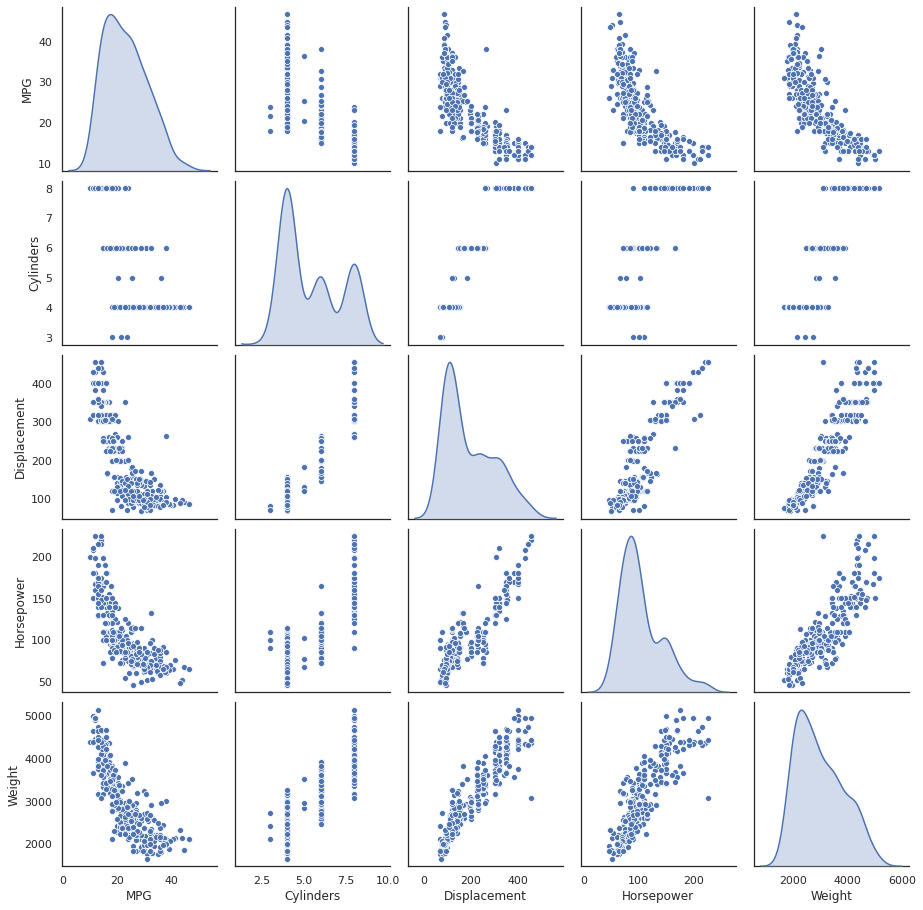

In [18]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Horsepower','Weight']], diag_kind='kde');

In [19]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 데이터의 특성과 레이블 분리

In [21]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 데이터 정규화

In [22]:
def normalization(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

### 모델 구성

In [23]:
def build_model():
  input = Input(shape=(len(train_dataset.keys())), name='input')
  hidden1 = Dense(64, activation='relu', name='dense1')(input)
  hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
  output = Dense(1, name='ouput')(hidden2)  
  
  model = Model(inputs=[input], outputs=output)

  model.compile(loss='mse',
                optimizer=RMSprop(.001),
                metrics=['mae','mse'])
  
  return model

In [24]:
model = build_model()

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 9)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                640       
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
ouput (Dense)                (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


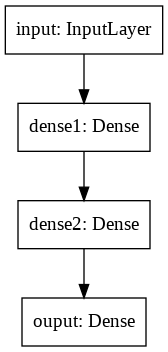

In [26]:
plot_model(model)

### 샘플 데이터 확인

In [28]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### 모델 학습

In [29]:
epochs = 1000

history = model.fit(normed_train_data, train_labels,
                    epochs = epochs, validation_split = 0.2)

Epoch 1/1000
8/8 [==============================] - 0s 26ms/step - loss: 553.5225 - mae: 22.2296 - mse: 553.5225 - val_loss: 538.1317 - val_mae: 21.7931 - val_mse: 538.1317
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 497.1138 - mae: 20.8671 - mse: 497.1138 - val_loss: 478.9978 - val_mae: 20.3033 - val_mse: 478.9978
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 440.1017 - mae: 19.3765 - mse: 440.1017 - val_loss: 416.2086 - val_mae: 18.6139 - val_mse: 416.2086
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 379.5724 - mae: 17.7352 - mse: 379.5724 - val_loss: 350.0752 - val_mae: 16.7579 - val_mse: 350.0752
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 317.3440 - mae: 15.9947 - mse: 317.3440 - val_loss: 284.7981 - val_mae: 14.8882 - val_mse: 284.7981
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 255.3192 - mae: 14.1787 - mse: 255.3192 - val_loss: 219.9751 - val_

### 모델 학습 시각화

In [30]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,553.522461,22.229607,553.522461,538.131714,21.793070,538.131714,0
1,497.113800,20.867062,497.113800,478.997772,20.303278,478.997772,1
2,440.101654,19.376484,440.101654,416.208557,18.613934,416.208557,2
3,379.572418,17.735172,379.572418,350.075226,16.757931,350.075226,3
4,317.343994,15.994724,317.343994,284.798126,14.888240,284.798126,4
...,...,...,...,...,...,...,...
995,2.737618,1.055442,2.737618,11.526126,2.567401,11.526126,995
996,2.411008,1.010240,2.411008,11.249253,2.589895,11.249253,996
997,2.653090,1.058475,2.653090,11.967157,2.628186,11.967157,997
998,2.458436,0.975992,2.458436,12.250533,2.634060,12.250533,998


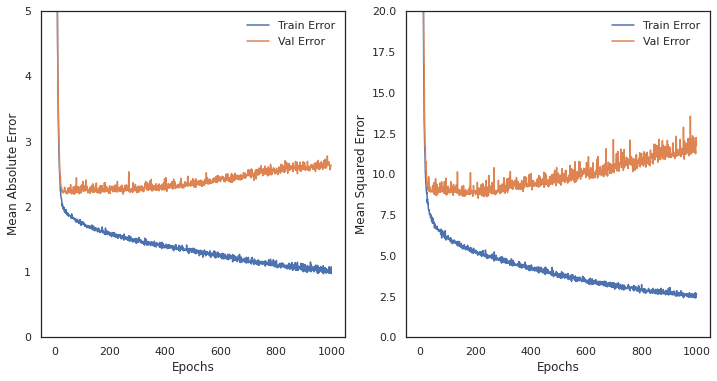

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.xlabel('Epochs')
  plt.ylabel('Mean Absolute Error')
  plt.plot(hist['epoch'],hist['mae'], label='Train Error')
  plt.plot(hist['epoch'],hist['val_mae'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epochs')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'],hist['mse'], label='Train Error')
  plt.plot(hist['epoch'],hist['val_mse'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()

plot_history(history)

### EarlyStopping을 이용한 규제화

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
model = build_model()

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normed_train_data, train_labels, epochs = epochs,
                    validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000
8/8 [==============================] - 0s 22ms/step - loss: 566.0046 - mae: 22.5053 - mse: 566.0046 - val_loss: 560.7686 - val_mae: 22.3217 - val_mse: 560.7686
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 521.8330 - mae: 21.4718 - mse: 521.8330 - val_loss: 514.3803 - val_mae: 21.2189 - val_mse: 514.3803
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 478.1678 - mae: 20.4084 - mse: 478.1678 - val_loss: 465.0845 - val_mae: 20.0030 - val_mse: 465.0845
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 430.4689 - mae: 19.2009 - mse: 430.4689 - val_loss: 410.9744 - val_mae: 18.5857 - val_mse: 410.9744
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 378.8621 - mae: 17.8022 - mse: 378.8621 - val_loss: 352.9362 - val_mae: 16.9601 - val_mse: 352.9362
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 323.7583 - mae: 16.2176 - mse: 323.7583 - val_loss: 291.8755 - val_

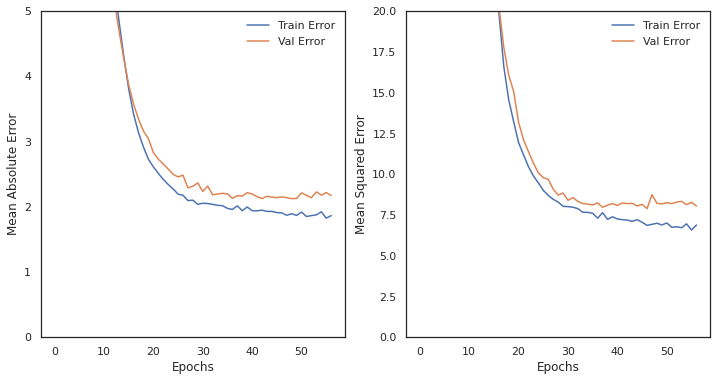

In [36]:
plot_history(history)

### 모델 평가

In [37]:
loss, mae, mse = model.evaluate(normed_test_data,test_labels, verbose=2)

print(mae)

3/3 - 0s - loss: 5.5284 - mae: 1.8392 - mse: 5.5284
1.8392175436019897


### 학습된 모델을 통한 예측

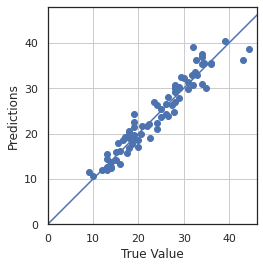

In [44]:
test_pred = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_pred)

plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100],[-100,100]);

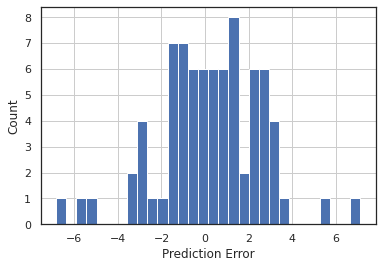

In [45]:
error = test_pred - test_labels
plt.hist(error, bins=30)
plt.xlabel('Prediction Error')
plt.grid()
plt.ylabel('Count');